# <font color='violet'> Complete Feature Engineering. Assign Ratings to Psychedelic Experience Reports & Analyze Findings
    
Drawing from scraped psychedelic experience reports that were cleaned here: https://github.com/fractaldatalearning/psychedelic_efficacy/blob/main/notebooks/9-kl-reports-clean-engineer.ipynb

In [104]:
import pandas as pd
from textblob import TextBlob
import spacy
import pickle
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# prepare to add local python functions; import modules from src directory
import sys
src = '../src'
sys.path.append(src)

# import local functions
from nlp.feature_engineer import analyze_sentiment

In [3]:
# Import data
df = pd.read_csv('../data/processed/erowid_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4562 entries, 0 to 4561
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     4562 non-null   int64  
 1   drug           4562 non-null   object 
 2   weight         4562 non-null   object 
 3   year           4562 non-null   object 
 4   gender         4562 non-null   object 
 5   age            4562 non-null   object 
 6   report         4562 non-null   object 
 7   complexity     4562 non-null   float64
 8   no_stops_lemm  4562 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 320.9+ KB


In [4]:
# Delete irrelevant columns
df = df.drop(columns=['Unnamed: 0', 'weight', 'gender'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4562 entries, 0 to 4561
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   drug           4562 non-null   object 
 1   year           4562 non-null   object 
 2   age            4562 non-null   object 
 3   report         4562 non-null   object 
 4   complexity     4562 non-null   float64
 5   no_stops_lemm  4562 non-null   object 
dtypes: float64(1), object(5)
memory usage: 214.0+ KB


<font color='violet'> Add additional columns that were part of the original model

In [5]:
# Analyze sentiment
analyze_sentiment(df, 'report')
df.head(3)

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442


In [6]:
# Measure the length of each review
df['review_len'] = [len(df.loc[row,'report']) for row in range(len(df))]
df.head(3)

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity,review_len
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679,5947
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717,9718
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442,11329


In [11]:
# Find similarity w/ the 10-rated meta-review from the original studies

# Get the original text to find similarity with
with open('../data/processed/rating_10_meta.txt', 'r') as file:
    rating_10_meta = file.read()

# Instantiate the spacy model
nlp = spacy.load('en_core_web_lg') 

# Turn the sting into a spacy doc
rating_10_meta = nlp(rating_10_meta)

# Create column
df['similarity_w_10'] = df.no_stops_lemm.apply(nlp).apply(
    lambda text: text.similarity(rating_10_meta))

df.head(3)

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity,review_len,similarity_w_10
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679,5947,0.892374
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717,9718,0.970629
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442,11329,0.964469


<font color='violet'> Prepare data & make predictions with pre-trained model to assign ratings.

In [18]:
# Rename the lemmatized text column to 'review' and 'polarity' to 'original_polarity'
X_unseen = df.rename(columns={'no_stops_lemm':'review', 'polarity':'original_polarity'})

# Isolate just rows used in the original model:
X_unseen = X_unseen[['review', 'review_len', 'complexity', 'subjectivity', 'original_polarity', 
                'similarity_w_10']]

X_unseen.head()

,review,review_len,complexity,subjectivity,original_polarity,similarity_w_10
0,see buddhanature dmt 22 year old male 102 ...,5947,7.9,0.386781,0.101679,0.892374
1,past week chance try aet 3 different dosage ...,9718,7.8,0.485326,0.104717,0.970629
2,800 pm \t 130 mg aet oral capsule t+315 \...,11329,7.2,0.536657,0.149442,0.964469
3,read people insuffulate bring quick burn eye...,1079,5.6,0.532292,0.207292,0.911463
4,mid late 80 aet legal available usual chemic...,1698,6.9,0.447603,0.140524,0.956280


In [21]:
# load pickled trained classifier with which to assign ratings
with open("../models/trained_model.pkl", "rb") as f:
    model = pickle.load(f)

# Assign ratings
ratings = model.predict(X_unseen)
ratings

array([4, 4, 4, ..., 4, 4, 4])

In [22]:
# Rejoin ratings to the original dataframe. 
df['rating'] = ratings
df.head()

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity,review_len,similarity_w_10,rating
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679,5947,0.892374,4
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717,9718,0.970629,4
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442,11329,0.964469,4
3,AET,2007,Not Given,i read about people insuffulating this to bri...,5.6,read people insuffulate bring quick burn eye...,0.532292,0.207292,1079,0.911463,4
4,AET,1986,Not Given,back in the mid to late 80s aet was legal and...,6.9,mid late 80 aet legal available usual chemic...,0.447603,0.140524,1698,0.956280,4


In [26]:
set(ratings)

{3, 4}

Every text was given a rating of 3 or 4. 

<font color='violet'> Initial Analysis
    
Here's what I noted about the model from when I first trained it:
- When the model predicted a score of 4, it's correct 73% of the time. It's within one point 89% of the time. 11% of the time, the rating should actually have been 1-3.
- When the model predicts a score of 3, it's correct 34% of the time. It's within one point 82% of the time. 18% of the time, the score should have been a 0-1
    
More specifically: 
I could add a column that takes into consideration this margin of error. From all rows that have a predicted rating of 4, re-assign 16% to have a rating of 3, 4% to have a rating of 2, 2% to have a rating of 1 and 5% to have a rating of 0. From all rows that have a predicted rating of 3, reassign 36% to have a rating of 4, 12% a rating of 2, 8% a rating of 1, and 10% a rating of 0. Do this reassignment randomly across the dataset. 

In [34]:
four_reassignment = [4]*73 + [3]*16 + [2]*4 + [1]*2 + [0]*5
three_reassignment = [4]*36 + [3]*34 + [2]*12 + [1]*8 + [0]*10

for row in range(len(df)):
    if df.loc[row,'rating'] == 4:
        df.loc[row,'adjusted_rating'] = random.choices(four_reassignment)
    else: df.loc[row,'adjusted_rating'] = random.choices(three_reassignment)

df.head()

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity,review_len,similarity_w_10,rating,adjusted_rating
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679,5947,0.892374,4,4.0
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717,9718,0.970629,4,4.0
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442,11329,0.964469,4,1.0
3,AET,2007,Not Given,i read about people insuffulating this to bri...,5.6,read people insuffulate bring quick burn eye...,0.532292,0.207292,1079,0.911463,4,4.0
4,AET,1986,Not Given,back in the mid to late 80s aet was legal and...,6.9,mid late 80 aet legal available usual chemic...,0.447603,0.140524,1698,0.956280,4,4.0


In [36]:
set(df.adjusted_rating)

{0.0, 1.0, 2.0, 3.0, 4.0}

In [37]:
# The model returns predicdtions of 0-4, but it's simpler to interpret ratings of 1-5

df['rating'] = df.rating + 1
df['adjusted_rating'] = df.adjusted_rating + 1

df.head()

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity,review_len,similarity_w_10,rating,adjusted_rating
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679,5947,0.892374,5,5.0
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717,9718,0.970629,5,5.0
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442,11329,0.964469,5,2.0
3,AET,2007,Not Given,i read about people insuffulating this to bri...,5.6,read people insuffulate bring quick burn eye...,0.532292,0.207292,1079,0.911463,5,5.0
4,AET,1986,Not Given,back in the mid to late 80s aet was legal and...,6.9,mid late 80 aet legal available usual chemic...,0.447603,0.140524,1698,0.956280,5,5.0


<AxesSubplot: xlabel='adjusted_rating', ylabel='Count'>

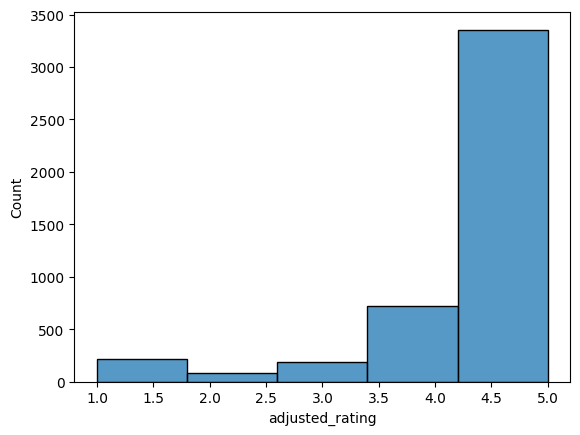

In [46]:
# Visualize distribution of adjusted ratings.
sns.histplot(df.adjusted_rating, bins=5)

<font color='violet'> Compare ratings across psychedelic drug types

In [48]:
# Create dictionary of drugs and the class they belong to. Import original list
drugs_file = open('../data/raw/erowid/psychedelic_drugs.txt', 'r')
drugs_as_string = drugs_file.read()
psychedelic_drugs = drugs_as_string.split(',')
psychedelic_drugs

['AET',
 'AL-LAD',
 'ALD-52',
 'ALEPH',
 'Aleph-4',
 'Allylescaline',
 'AMT',
 'Arylcyclohexylamines',
 'Ayahuasca',
 'Banisteriopsis caapi',
 'BOD',
 'BOH-2C-B',
 'Bufotenin',
 'Cacti - Mescaline-containing',
 'DALT',
 'Deschloroketamine',
 'DET',
 'DiPT',
 'DMT',
 'DMT-Containing',
 'DMXE',
 'DOB',
 'DOC',
 'DOET',
 'DOF',
 'DOI',
 'DOIP',
 'DOM',
 'DON',
 'DOPR',
 'DPT',
 'EIPLA',
 'EPT',
 'Escaline',
 'ETH-LAD',
 'Fluorexetamine',
 'H.B. Woodrose',
 'Harmaline',
 'Harmine',
 'Herbal Ecstasy',
 'HOT-17',
 'HOT-2',
 'HOT-7',
 'Huasca Brew',
 'Huasca Brew Group',
 'Huasca Combo',
 'Huasca Group',
 'HXE',
 'Iboga Alkaloid Group',
 'Ibogaine',
 'Isoproscaline',
 'Ketamine',
 'LSA',
 'LSD',
 'LSM-775',
 'LSZ',
 'MALT',
 'MDA',
 'MDAI',
 'MDE',
 'MDMA',
 'MEM',
 'Mescaline',
 'MET',
 'Methallylescaline',
 'Methoxetamine',
 'Methoxpropamine',
 'Mimosa ophthalmocentra',
 'Mimosa spp.',
 'Mimosa tenuiflora',
 'MIPLA',
 'MIPT',
 'MMDA',
 'MMDA-3a',
 'MPT',
 'Mushrooms',
 'Mushrooms - G. spect

In [49]:
drug_class_dict = {'AET':'tryptamine', 'AL-LAD':'tryptamine', 'ALD-52':'tryptamine',
                   'ALEPH':'phenethylamine', 'Aleph-4':'phenethylamine',
                   'Allylescaline':'phenethylamine', 'AMT':'tryptamine',
                   'Arylcyclohexylamines':'arylcyclohexylamine', 'Ayahuasca':'tryptamine',
                   'Banisteriopsis caapi':'other entheogen', 'BOD':'phenethylamine', 
                   'BOH-2C-B':'phenethylamine', 'Bufotenin':'tryptamine',
                   'Cacti - Mescaline-containing':'phenethylamine', 'DALT':'tryptamine',
                   'Deschloroketamine':'arylcyclohexylamine', 'DET':'tryptamine',
                   'DiPT':'tryptamine', 'DMT':'tryptamine', 'DMT-Containing':'tryptamine',
                   'DMXE':'arylcyclohexylamine', 'DOB':'phenethylamine', 
                   'DOC':'phenethylamine', 'DOET':'phenethylamine', 'DOF':'phenethylamine',
                   'DOI':'phenethylamine', 'DOIP':'phenethylamine', 'DOM':'phenethylamine',
                   'DON':'phenethylamine', 'DOPR':'phenethylamine', 'DPT':'tryptamine',
                   'EIPLA':'tryptamine', 'EPT':'tryptamine', 'Escaline':'phenethylamine',
                   'ETH-LAD':'tryptamine', 'Fluorexetamine':'arylcyclohexylamine',
                   'H.B. Woodrose':'other entheogen', 'Harmaline':'other entheogen',
                   'Harmine':'other entheogen', 'Herbal Ecstasy':'other entheogen',
                   'HOT-17':'phenethylamine', 'HOT-2':'phenethylamine', 
                   'HOT-7':'phenethylamine', 'Huasca Brew':'tryptamine', 
                   'Huasca Brew Group':'tryptamine', 'Huasca Combo':'tryptamine',
                   'Huasca Group':'tryptamine', 'HXE':'arylcyclohexylamine',
                   'Iboga Alkaloid Group':'other entheogen', 'Ibogaine':'other entheogen',
                   'Isoproscaline':'phenethylamine', 'Ketamine':'arylcyclohexylamine',
                   'LSA':'tryptamine', 'LSD':'tryptamine', 'LSM-775':'tryptamine',
                   'LSZ':'tryptamine', 'MALT':'tryptamine', 'MDA':'phenethylamine', 
                   'MDAI':'phenethylamine', 'MDE':'phenethylamine', 'MDMA':'phenethylamine', 
                   'MEM':'phenethylamine', 'Mescaline':'phenethylamine', 'MET':'tryptamine',
                   'Methallylescaline':'phenethylamine', 
                   'Methoxetamine':'arylcyclohexylamine',
                   'Methoxpropamine':'arylcyclohexylamine', 
                   'Mimosa ophthalmocentra':'other entheogen', 
                   'Mimosa spp.':'other entheogen', 
                   'Mimosa tenuiflora':'other entheogen', 'MIPLA':'tryptamine', 
                   'MIPT':'tryptamine', 'MMDA':'phenethylamine', 'MMDA-3a':'phenethylamine', 
                   'MPT':'tryptamine', 'Mushrooms':'tryptamine', 
                   'Mushrooms - G. spectabilis':'tryptamine', 
                   'Mushrooms - P. atlantis':'tryptamine', 
                   'Mushrooms - P. azurescens':'tryptamine', 
                   'Mushrooms - P. cubensis':'tryptamine', 
                   'Mushrooms - P. cyanescens':'tryptamine', 
                   'Mushrooms - P. mexicana':'tryptamine', 
                   'Mushrooms - P. semilanceata':'tryptamine', 
                   'Mushrooms - P. subaeruginosa':'tryptamine', 
                   'Mushrooms - P. tampanensis':"tryptamine",
                   'Mushrooms - P. weilii':'tryptamine',
                   'Mushrooms - Panaeolus cyanescens':'tryptamine', 
                   'MXiPr':'arylcyclohexylamine', 'PCE':'arylcyclohexylamine', 
                   'PCP':'arylcyclohexylamine', 'Peyote':'other entheogen', 
                   'Phenethylamine':'phenethylamine', 'Phenethylamines':'phenethylamine', 
                   'Phenethylamines - Other':'phenethylamine', 'PIPT':'tryptamine', 
                   'Proscaline':'phenethylamine', 'Psilocin':'tryptamine', 
                   'Psilocybin':'tryptamine', 'S-Ketamine':'arylcyclohexylamine', 
                   'Tabernanthe iboga':'other entheogen', 'TCB-2':'phenethylamine', 
                   'Tetrahydroharmine':'other entheogen', 'TMA':'phenethylamine', 
                   'TMA-2':'phenethylamine', 'TMA-6':'phenethylamine', 
                   'Tryptamines - Substituted':'tryptamine', '1B-LSD':'tryptamine', 
                   '1cP-AL-LAD':'tryptamine', '1cP-LSD':'tryptamine', '1F-LSD':'tryptamine', 
                   '1P-ETH-LAD':'tryptamine', '1P-LSD':'tryptamine', '1V-LSD':'tryptamine', 
                   "2'-Oxo-PCE":'arylcyclohexylamine', 
                   '2-Fluorodeschloroketamine':'arylcyclohexylamine', '2-Me-DMT':'tryptamine', 
                   '2C-B':'phenethylamine', '2C-B-Fly':'phenethylamine', 
                   '2C-C':'phenethylamine', '2C-CN':'phenethylamine', '2C-D':'phenethylamine', 
                   '2C-E':'phenethylamine', '2C-EF':'phenethylamine', 
                   '2C-G-N':'phenethylamine', '2C-H':'phenethylamine', 
                   '2C-I':'phenethylamine', 
                   '2C-IP':'phenethylamine', '2C-N':'phenethylamine', '2C-P':'phenethylamine',
                   '2C-T':'phenethylamine', '2C-T-13':'phenethylamine',
                   '2C-T-2':'phenethylamine', '2C-T-21':'phenethylamine', 
                   '2C-T-4':'phenethylamine', '2C-T-7':'phenethylamine', 
                   '2C-TFM':'phenethylamine', '4-MD-PCP':'arylcyclohexylamine', 
                   '3-Cl-PCP':'arylcyclohexylamine', '3-HO-PCE':'arylcyclohexylamine', 
                   '3-HO-PCP':'arylcyclohexylamine', '3-Me-PCE':'arylcyclohexylamine', 
                   '3-Me-PCPy':'arylcyclohexylamine', '3-MEO-PCE':'arylcyclohexylamine', 
                   '3-MeO-PCMo':'arylcyclohexylamine', '3-MeO-PCP':'arylcyclohexylamine', 
                   '3-Methyl-PCP':'arylcyclohexylamine', '3C-E':'phenethylamine', 
                   '3C-P':'phenethylamine', '3F-PCP':'phenethylamine', 
                   '4-AcO-DALT':'tryptamine', '4-AcO-DET':'tryptamine', 
                   '4-AcO-DiPT':'tryptamine', '4-AcO-DMT':'tryptamine', 
                   '4-AcO-DPT':'tryptamine', '4-AcO-EIPT':'tryptamine', 
                   '4-AcO-EPT':'tryptamine', '4-AcO-MALT':'tryptamine', 
                   '4-AcO-MET':'tryptamine', '4-AcO-MiPT':'tryptamine', 
                   '4-AcO-MPT':'tryptamine', '4-HO-DET':'tryptamine', 
                   '4-HO-DiPT':'tryptamine', 
                   '4-HO-DPT':'tryptamine', '4-HO-EPT':'tryptamine', 
                   '4-HO-MALT':'tryptamine', 
                   '4-HO-MCPT':'tryptamine', '4-HO-MET':'tryptamine', 
                   '4-HO-MiPT':'tryptamine', 
                   '4-HO-MPT':'tryptamine', '4-HO-PIPT':'tryptamine', 
                   '4-MeO-DMT':'tryptamine', 
                   '4-MeO-MiPT':'tryptamine', '4-MeO-PCP':'arylcyclohexylamine', 
                   '4-MTA':'phenethylamine', '4-PrO-DMT':'tryptamine', 
                   '4C-D':'phenethylamine', 
                   '5-Chloro-AMT':'tryptamine', '5-MeO-AET':'tryptamine', 
                   '5-MeO-AMT':'tryptamine', '5-MeO-DALT':'tryptamine', 
                   '5-MeO-DET':'tryptamine', '5-MeO-DiPT':'tryptamine', 
                   '5-MeO-DMT':'tryptamine', '5-MeO-DPT':'tryptamine', 
                   '5-MeO-EIPT':'tryptamine', '5-MeO-MALT':'tryptamine', 
                   '5-MeO-MET':'tryptamine', '5-MeO-MIPT':'tryptamine', 
                   '5-MeO-PIPT':'tryptamine', '5-MeO-TMT':'tryptamine',
                   '5-Methoxy-Tryptamine':'tryptamine'}

In [53]:
df['drug_class'] = [drug_class_dict[df.loc[row,'drug']] for row in range(len(df))]
df.head()

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity,review_len,similarity_w_10,rating,adjusted_rating,drug_class
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679,5947,0.892374,5,5,tryptamine
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717,9718,0.970629,5,5,tryptamine
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442,11329,0.964469,5,2,tryptamine
3,AET,2007,Not Given,i read about people insuffulating this to bri...,5.6,read people insuffulate bring quick burn eye...,0.532292,0.207292,1079,0.911463,5,5,tryptamine
4,AET,1986,Not Given,back in the mid to late 80s aet was legal and...,6.9,mid late 80 aet legal available usual chemic...,0.447603,0.140524,1698,0.956280,5,5,tryptamine


In [60]:
# Is there much difference among the drug class ratings?
avg_rating_by_class = df.groupby('drug_class')['adjusted_rating'].mean()
avg_rating_by_class

drug_class
arylcyclohexylamine    4.497817
other entheogen        4.428922
phenethylamine         4.509979
tryptamine             4.539010
Name: adjusted_rating, dtype: float64

Differences in ratings across drug classes are minimal, and average ratings are higher than for prescription drugs from the original study (average rating there was approximately 3.7, still high but lower than this).

Because the original data was skewed toward perfect ratings, I assume my model might over-assigns perfect ratings, and this may be even more so the case when features don't line up exactly as with words this unseen data's vector. A more sensitive model with improved feature engineering might result in a wider range of ratings being predicted for various experience reports. It could also be the case that people are, in general, describing their experiences with psychedelic drugs more favorably than people described their experiences with prescription meds. 

For now, dig in further to this data, and do more to compare with the original studies. 

<font color='violet'> Analyze relationships across multiple variables & datasets

In [65]:
psychedelic_df = df
studies_df = pd.read_csv('../data/processed/studies_w_vector_similarity.csv').drop(
    columns=['Unnamed: 0'])
studies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31557 entries, 0 to 31556
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   condition          31557 non-null  object 
 1   date               31557 non-null  object 
 2   drug0              31557 non-null  object 
 3   drug1              31557 non-null  object 
 4   review_len         31557 non-null  int64  
 5   complexity         31557 non-null  float64
 6   no_stop_cap_lemm   31557 non-null  object 
 7   subjectivity       31557 non-null  float64
 8   original_polarity  31557 non-null  float64
 9   set                31557 non-null  object 
 10  rating             31557 non-null  float64
 11  similarity_w_10    31557 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.9+ MB


In [67]:
# Turn studies' ratings into 1-5 scale for simpler comparison with psychedelic ratings
studies_df['adjusted_rating'] = studies_df.rating.replace({2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4, 
                                                          9:5, 10:5}).astype(int)
studies_df.head()

,condition,date,drug0,drug1,review_len,complexity,no_stop_cap_lemm,subjectivity,original_polarity,set,rating,similarity_w_10,adjusted_rating
0,anxiety,2013-12-14,escitalopram,lexapro,36,-1.2,good give run gas,0.600000,0.700000,train,9.0,0.640050,5
1,anxiety,2017-03-13,pregabalin,na,547,5.4,75 mg x daily no noticeable effect 150 mg x da...,0.343056,0.031439,train,8.0,0.841263,4
2,depression,2016-10-16,mirtazapine,na,390,4.8,take 145 mg 10 year fantastic insomnia really ...,0.591667,0.096296,train,8.0,0.922576,4
3,bpd,2017-08-16,quetiapine,na,156,8.2,help stability mood help insomnia start experi...,1.000000,-1.000000,train,7.0,0.825203,4
4,depression,2014-09-19,fluoxetine,prozac,66,-0.4,crazy eat sleep sit,0.900000,-0.600000,train,2.0,0.467668,1


In [70]:
# When were the different reviews/reports submitted? Start by cleaning up date column.
set(psychedelic_df.year)

{'1962',
 '1963',
 '1964',
 '1967',
 '1968',
 '1969',
 '1970',
 '1972',
 '1973',
 '1975',
 '1979',
 '1980',
 '1981-2007',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2001 2008',
 '2002',
 '2003',
 '2003-2004',
 '2004',
 '2005',
 '2005-2007',
 '2006',
 '2006-2007',
 '2006-2019',
 '2007',
 '2008',
 '2009',
 '2009-2010',
 '2010',
 '2011',
 '2011-2013',
 '2011-2018',
 '2012',
 '2012-2013',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2018-2019',
 '2019',
 '2020',
 '2020-2021',
 '2021',
 '2021-2022',
 '2022',
 '2023',
 'Exp Year:'}

In [85]:
psychedelic_df['year'] = psychedelic_df.year.replace({'1981-2007':'1981', '2001 2008':'2001',
                                                     '2003-2004':'2003', '2005-2007':'2005',
                                                     '2006-2007':'2006', '2006-2019':'2006',
                                                     '2009-2010':'2009', '2011-2013':'2011',
                                                     '2011-2018':'2011', '2012-2013':'2012',
                                                     '2018-2019':'2018', '2020-2021':'2020',
                                                     '2021-2022':'2021', 'Exp Year:':''})
psychedelic_df['year'] = pd.to_datetime(psychedelic_df.year)
psychedelic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4562 entries, 0 to 4561
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   drug             4562 non-null   object        
 1   year             4561 non-null   datetime64[ns]
 2   age              4562 non-null   object        
 3   report           4562 non-null   object        
 4   complexity       4562 non-null   float64       
 5   no_stops_lemm    4562 non-null   object        
 6   subjectivity     4562 non-null   float64       
 7   polarity         4562 non-null   float64       
 8   review_len       4562 non-null   int64         
 9   similarity_w_10  4562 non-null   float64       
 10  rating           4562 non-null   int64         
 11  adjusted_rating  4562 non-null   int64         
 12  drug_class       4562 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memory usage: 463.5+ KB


In [98]:
studies_df['year'] = pd.to_datetime(studies_df.date, errors='raise', format='Y')
studies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31557 entries, 0 to 31556
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   condition          31557 non-null  object        
 1   date               31557 non-null  datetime64[ns]
 2   drug0              31557 non-null  object        
 3   drug1              31557 non-null  object        
 4   review_len         31557 non-null  int64         
 5   complexity         31557 non-null  float64       
 6   no_stop_cap_lemm   31557 non-null  object        
 7   subjectivity       31557 non-null  float64       
 8   original_polarity  31557 non-null  float64       
 9   set                31557 non-null  object        
 10  rating             31557 non-null  float64       
 11  similarity_w_10    31557 non-null  float64       
 12  adjusted_rating    31557 non-null  int64         
 13  year               31557 non-null  datetime64[ns]
dtypes: dat

In [100]:
studies_df['year'] = [studies_df.loc[row,'year'].year for row in range(len(studies_df))]
studies_df.year[:3]

0    2013
1    2017
2    2016
Name: year, dtype: int64

In [108]:
# Find how many reviews/reports were submitted each year
psychedelic_year_count = psychedelic_df.groupby('year')['adjusted_rating'].count().sort_values(
    ascending=False)
studies_year_count = studies_df.groupby('year')['adjusted_rating'].count().sort_values(
    ascending=False)

psychedelic_year_count

year
2003-01-01    332
2004-01-01    306
2012-01-01    267
2011-01-01    242
2005-01-01    241
2007-01-01    234
2010-01-01    233
2006-01-01    223
2014-01-01    215
2002-01-01    214
2016-01-01    203
2001-01-01    202
2008-01-01    185
2013-01-01    183
2017-01-01    170
2009-01-01    146
2018-01-01    145
2015-01-01    144
2020-01-01    132
2000-01-01    126
2021-01-01    123
2022-01-01    102
2019-01-01     98
1999-01-01     27
1998-01-01     14
1970-01-01      5
1992-01-01      4
1995-01-01      4
1997-01-01      4
2023-01-01      3
1975-01-01      3
1993-01-01      3
1989-01-01      3
1994-01-01      2
1968-01-01      2
1986-01-01      2
1985-01-01      2
1969-01-01      2
1979-01-01      2
1963-01-01      1
1964-01-01      1
1967-01-01      1
1972-01-01      1
1973-01-01      1
1981-01-01      1
1980-01-01      1
1996-01-01      1
1984-01-01      1
1987-01-01      1
1988-01-01      1
1990-01-01      1
1962-01-01      1
Name: adjusted_rating, dtype: int64

In [ ]:
fig, axes = plt.subplots(2,1)

sns.lineplot()